# Q2 — WiFi RSSI Fingerprinting for Indoor Localization

This notebook follows the coursework brief:

- **2.1 Multi-Linear Regression**: build a baseline model to predict $(x,y)$ from RSSI fingerprints and report **validation MSE**.
- **2.2 Neural Network**: build a NN regressor and compare its **validation performance** to linear regression.
- **2.3 Feature visualization**: extract NN embeddings, cluster **without using $(x,y)$ labels**, and visualize with 2D dimensionality reduction.

Notes:
- The dataset provides each scan as two comma-separated lists: `mac_addrs_idx` (AP indices) and `rssi` (dB).
- We use a **train/validation split** (no separate held-out test set in this notebook).

In [1]:
# Import Required Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

# Neural Network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## 2.1 Multi-Linear Regression Model for Indoor Localization

In this section we implement the baseline requested in the brief.

**Key preprocessing choices (brief note about NaNs):**
- Each scan observes only a subset of APs, so a fixed-length RSSI vector naturally contains many missing entries.
- We build a fixed-length feature vector over **all observed AP indices**, and treat “missing AP” as *no signal* by imputing to **-100 dB** (addresses the NaNs mentioned in the brief).
- We optionally remove near-constant AP features (variance threshold) and add a few simple engineered features (AP count, RSSI mean/max/std).

We then fit two linear regressors (one for $x$ and one for $y$) and report **validation MSE** (plus a couple of extra diagnostics for interpretation).

In [2]:
# Data Loading and Preprocessing

# Load the dataset
df = pd.read_csv('data/Wifi_train_dataset.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())

# Parse RSSI and MAC address strings into lists
rssi_lists = df['rssi'].apply(lambda x: [float(v) for v in x.split(',')])
mac_lists = df['mac_addrs_idx'].apply(lambda x: [int(v) for v in x.split(',')])

# Find all unique MAC addresses to create fixed-length feature space
all_macs = set()
for mac_list in mac_lists:
    all_macs.update(mac_list)
all_macs = sorted(list(all_macs))
n_macs = len(all_macs)

print(f"\nFound {n_macs} unique MAC addresses (access points)")

# Create mapping from MAC address to column index
mac_to_idx = {mac: idx for idx, mac in enumerate(all_macs)}

# Create fixed-length feature matrix (one column per MAC address)
n_samples = len(df)
X = np.full((n_samples, n_macs), np.nan)  # Initialize with NaN

for i in range(n_samples):
    rssi_vals = rssi_lists.iloc[i]
    mac_vals = mac_lists.iloc[i]

    # Populate feature vector at correct MAC positions
    for rssi, mac in zip(rssi_vals, mac_vals):
        col_idx = mac_to_idx[mac]
        X[i, col_idx] = rssi

print(f"\nCreated feature matrix: {X.shape}")
print(f"NaN values: {np.isnan(X).sum():,} ({100 * np.isnan(X).sum() / X.size:.2f}% of total)")

# Impute with -100 dB (no signal indicator)
X_imputed = np.nan_to_num(X, nan=-100.0)
print(f"Imputed NaN values with -100 dB (no signal indicator)")

# Remove low-variance features (APs that are almost always -100)
print("\n" + "="*60)
print("FEATURE SELECTION")
print("="*60)
variance_threshold = VarianceThreshold(threshold=1.0)
X_selected = variance_threshold.fit_transform(X_imputed)
n_features_removed = n_macs - X_selected.shape[1]

print(f"Removed {n_features_removed} low-variance features")
print(f"Remaining features: {X_selected.shape[1]}")

# Add engineered features
print("\nAdding engineered features...")

# Feature 1: Number of APs detected (non -100 values)
n_aps_detected = np.sum(X_imputed > -100, axis=1).reshape(-1, 1)

# Feature 2: Mean RSSI of detected APs
mean_rssi = np.zeros((n_samples, 1))
for i in range(n_samples):
    detected = X_imputed[i, X_imputed[i] > -100]
    mean_rssi[i] = detected.mean() if len(detected) > 0 else -100

# Feature 3: Max RSSI (strongest signal)
max_rssi = np.max(X_imputed, axis=1).reshape(-1, 1)

# Feature 4: Std of detected RSSI values
std_rssi = np.zeros((n_samples, 1))
for i in range(n_samples):
    detected = X_imputed[i, X_imputed[i] > -100]
    std_rssi[i] = detected.std() if len(detected) > 1 else 0

# Combine original features with engineered features
X_enhanced = np.hstack([X_selected, n_aps_detected, mean_rssi, max_rssi, std_rssi])

print(f"Added 4 engineered features")
print(f"Total features: {X_enhanced.shape[1]}")
print(f"  - Number of APs detected")
print(f"  - Mean RSSI of detected APs")
print(f"  - Maximum RSSI (strongest signal)")
print(f"  - Standard deviation of RSSI")

# Prepare targets
y = df[['x', 'y']]

# ------------------------------------------------------------
# Train / Validation split (per coursework Section 2.2)
# - Train: used for fitting models / NN optimization
# - Val:   used for early stopping and reporting results
# ------------------------------------------------------------
val_size = 0.15
X_train, X_val, y_train, y_val = train_test_split(
    X_enhanced, y, test_size=val_size, random_state=42
)

print(f"\nTraining set size:   {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Feature Scaling
print("\n" + "="*60)
print("FEATURE SCALING")
print("="*60)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Features scaled using StandardScaler")
print(f"Training features shape:   {X_train_scaled.shape}")
print(f"Validation features shape: {X_val_scaled.shape}")
print("="*60)


Dataset shape: (2880, 4)

First few rows:
           x          y                                               rssi  \
0  39.300458 -33.832626  -76,-84,-76,-78,-76,-79,-79,-76,-83,-46,-46,-4...   
1  45.667780 -17.235028  -81,-82,-82,-82,-65,-65,-65,-65,-71,-71,-71,-7...   
2  79.944219 -54.821975  -88,-88,-88,-88,-78,-78,-78,-78,-67,-66,-66,-6...   
3  57.353449 -30.499641  -88,-91,-91,-61,-61,-61,-62,-88,-92,-92,-79,-9...   
4  54.454364 -16.056419  -84,-88,-84,-88,-84,-88,-84,-88,-83,-82,-82,-8...   

                                       mac_addrs_idx  
0  68,251,65,46,66,47,48,78,183,95,96,97,143,212,...  
1  126,127,128,129,59,56,57,60,86,85,58,87,120,12...  
2  1,2,3,4,290,289,288,291,5,6,7,8,23,21,152,154,...  
3  113,114,115,1,2,3,4,184,185,186,78,76,119,81,5...  
4  45,68,46,65,47,66,48,78,95,98,96,97,59,56,57,6...  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dt

### 2.1 Preprocessing: RSSI fingerprint construction

This cell:
- Loads `data/Wifi_train_dataset.csv`.
- Parses `mac_addrs_idx` and `rssi` into lists per scan.
- Builds a fixed-length matrix $X$ where each column corresponds to one AP index.
- Handles missing AP readings by imputing NaNs to **-100 dB**.
- Applies a variance filter to drop APs that are almost always missing.
- Adds 4 engineered features: `#APs detected`, `mean RSSI`, `max RSSI`, `std RSSI`.
- Splits into **train/validation** and standardizes features using `StandardScaler` fit on train only.

In [3]:
# Task i: Multi-Linear Regression Model

print("="*60)
print("TASK i: DEVELOPING MULTI-LINEAR REGRESSION MODEL")
print("="*60)

# Build separate models for X and Y coordinates
model_x = LinearRegression()
model_y = LinearRegression()

# Train the models on scaled training data
model_x.fit(X_train_scaled, y_train['x'])
model_y.fit(X_train_scaled, y_train['y'])

print("\n✓ Models trained successfully!")
print(f"  Model X: {len(model_x.coef_)} coefficients, Intercept: {model_x.intercept_:.4f}")
print(f"  Model Y: {len(model_y.coef_)} coefficients, Intercept: {model_y.intercept_:.4f}")
print("="*60)

TASK i: DEVELOPING MULTI-LINEAR REGRESSION MODEL

✓ Models trained successfully!
  Model X: 511 coefficients, Intercept: 48.8683
  Model Y: 511 coefficients, Intercept: -27.3309


### 2.1(i) Baseline model: multi-linear regression

We fit a simple baseline requested in the brief.

Implementation detail: because the target is 2D, we train **two** `LinearRegression` models:
- one predicts $x$ from the RSSI feature vector,
- one predicts $y$ from the same features.

This is equivalent to a multi-output linear model but keeps the implementation explicit.

TASK ii: MODEL PERFORMANCE ON VALIDATION SET

Mean Squared Error (X coordinate): 17.7600
Mean Squared Error (Y coordinate): 21.6624

>>> Overall Mean Squared Error: 19.7112 <<<

Additional Metrics:
  RMSE (X coordinate): 4.2143
  RMSE (Y coordinate): 4.6543
  Overall RMSE: 4.4397

  R² Score (X coordinate): 0.9097
  R² Score (Y coordinate): 0.7999

------------------------------------------------------------
Sample Predictions vs Actual Values (First 5)
------------------------------------------------------------
 Actual_X  Predicted_X  Error_X   Actual_Y  Predicted_Y  Error_Y
59.779089    57.889993 1.889097 -30.530006   -33.249706 2.719701
55.781606    58.847651 3.066045 -18.976056   -21.801406 2.825350
30.571793    26.814239 3.757555 -37.548512   -42.672037 5.123525
39.217118    35.553828 3.663290 -34.819949   -33.329630 1.490318
51.736434    49.198835 2.537599 -33.385827   -27.737877 5.647950

Generating visualization...


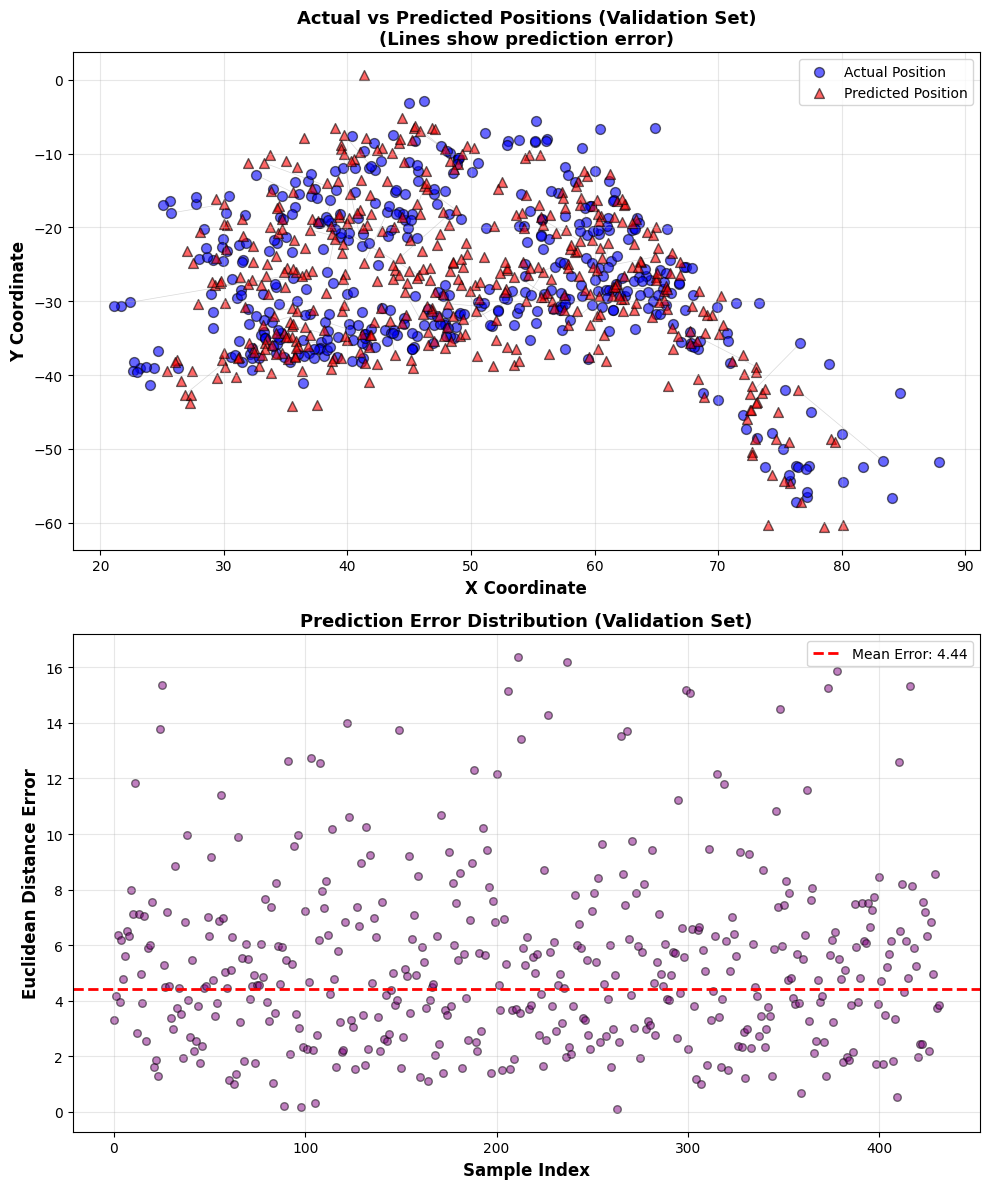

✓ Visualization complete!


In [4]:
# Task ii: Report Model Performance on Validation Set

print("="*60)
print("TASK ii: MODEL PERFORMANCE ON VALIDATION SET")
print("="*60)

# Make predictions on validation set
y_pred_x = model_x.predict(X_val_scaled)
y_pred_y = model_y.predict(X_val_scaled)

# Calculate Mean Squared Error for each coordinate
mse_x = mean_squared_error(y_val['x'], y_pred_x)
mse_y = mean_squared_error(y_val['y'], y_pred_y)

# Calculate overall MSE (average of both coordinates)
mse_overall = (mse_x + mse_y) / 2

print(f"\nMean Squared Error (X coordinate): {mse_x:.4f}")
print(f"Mean Squared Error (Y coordinate): {mse_y:.4f}")
print(f"\n>>> Overall Mean Squared Error: {mse_overall:.4f} <<<")
print("="*60)

# Additional metrics
rmse_x = float(np.sqrt(mse_x))
rmse_y = float(np.sqrt(mse_y))
rmse_overall = float(np.sqrt(mse_overall))

print(f"\nAdditional Metrics:")
print(f"  RMSE (X coordinate): {rmse_x:.4f}")
print(f"  RMSE (Y coordinate): {rmse_y:.4f}")
print(f"  Overall RMSE: {rmse_overall:.4f}")

# Calculate R² scores
r2_x = r2_score(y_val['x'], y_pred_x)
r2_y = r2_score(y_val['y'], y_pred_y)

print(f"\n  R² Score (X coordinate): {r2_x:.4f}")
print(f"  R² Score (Y coordinate): {r2_y:.4f}")

# Display some sample predictions
print("\n" + "-"*60)
print("Sample Predictions vs Actual Values (First 5)")
print("-"*60)
comparison = pd.DataFrame({
    'Actual_X': y_val['x'].values[:5],
    'Predicted_X': y_pred_x[:5],
    'Error_X': np.abs(y_val['x'].values[:5] - y_pred_x[:5]),
    'Actual_Y': y_val['y'].values[:5],
    'Predicted_Y': y_pred_y[:5],
    'Error_Y': np.abs(y_val['y'].values[:5] - y_pred_y[:5])
})
print(comparison.to_string(index=False))
print("="*60)

# Visualization: Predicted vs Actual Positions
print("\nGenerating visualization...")

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot 1: 2D Position Scatter (Actual vs Predicted)
ax1 = axes[0]
ax1.scatter(y_val['x'], y_val['y'], alpha=0.6, s=50, c='blue', label='Actual Position', edgecolors='black')
ax1.scatter(y_pred_x, y_pred_y, alpha=0.6, s=50, c='red', marker='^', label='Predicted Position', edgecolors='black')

# Draw lines connecting actual to predicted for first 50 points (to avoid clutter)
for i in range(min(50, len(y_val))):
    ax1.plot([y_val['x'].values[i], y_pred_x[i]],
             [y_val['y'].values[i], y_pred_y[i]],
             'gray', alpha=0.3, linewidth=0.5)

ax1.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
ax1.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
ax1.set_title('Actual vs Predicted Positions (Validation Set)\n(Lines show prediction error)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Residual Plot
ax2 = axes[1]
errors = np.sqrt((y_val['x'].values - y_pred_x)**2 + (y_val['y'].values - y_pred_y)**2)
ax2.scatter(range(len(errors)), errors, alpha=0.5, s=30, c='purple', edgecolors='black')
ax2.axhline(y=rmse_overall, color='red', linestyle='--', linewidth=2, label=f'Mean Error: {rmse_overall:.2f}')
ax2.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Euclidean Distance Error', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Error Distribution (Validation Set)', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete!")


### 2.1(ii) Validation performance (required: MSE)

Per the brief, we report **Mean Squared Error (MSE)** on the **validation** set.

For localization interpretability, we also compute:
- RMSE (just $\sqrt{\text{MSE}}$),
- $R^2$ per coordinate,
- Euclidean position error per sample (distance between predicted and true $(x,y)$).

EXPLORING MODEL IMPROVEMENTS WITH ELASTICNET

ElasticNet combines Ridge (L2) and Lasso (L1) regularization
to balance feature selection with stability.

Training ElasticNet models with cross-validation...
✓ Best alpha for X: 0.08, L1 ratio: 0.50
✓ Best alpha for Y: 0.08, L1 ratio: 0.50

ElasticNet MSE (X) on validation: 16.9514
ElasticNet MSE (Y) on validation: 19.3956
ElasticNet Overall MSE on validation: 18.1735

ElasticNet selected 265/511 features for X
ElasticNet selected 278/511 features for Y

COMPARISON (VALIDATION SET): Linear Regression vs ElasticNet
Model                          MSE (X)         MSE (Y)         Overall MSE    
---------------------------------------------------------------------------
Linear Regression              17.7600         21.6624         19.7112        
ElasticNet                     16.9514         19.3956         18.1735        

✓ Improvement: 7.80% reduction in MSE
✓ ElasticNet achieved better generalization through regularization


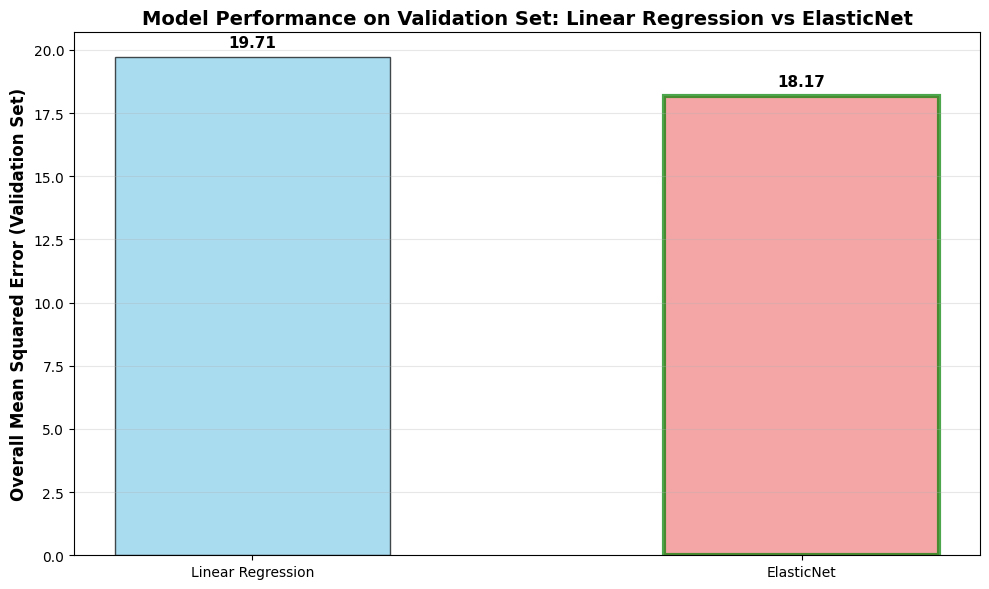


💡 Key Insight:
   ElasticNet's hybrid L1+L2 regularization reduces overfitting
   by performing feature selection while maintaining stability.


In [5]:
# Potential Improvement: ElasticNet with Cross-Validation

print("="*60)
print("EXPLORING MODEL IMPROVEMENTS WITH ELASTICNET")
print("="*60)

print("\nElasticNet combines Ridge (L2) and Lasso (L1) regularization")
print("to balance feature selection with stability.\n")

# Define range of alpha values to test
alphas = np.logspace(-2, 3, 50)

# ElasticNet with cross-validation
print("Training ElasticNet models with cross-validation...")
elastic_cv_x = ElasticNetCV(alphas=alphas, cv=5, max_iter=10000, l1_ratio=[0.1, 0.5, 0.7, 0.9])
elastic_cv_y = ElasticNetCV(alphas=alphas, cv=5, max_iter=10000, l1_ratio=[0.1, 0.5, 0.7, 0.9])

elastic_cv_x.fit(X_train_scaled, y_train['x'])
elastic_cv_y.fit(X_train_scaled, y_train['y'])

print(f"✓ Best alpha for X: {elastic_cv_x.alpha_:.2f}, L1 ratio: {elastic_cv_x.l1_ratio_:.2f}")
print(f"✓ Best alpha for Y: {elastic_cv_y.alpha_:.2f}, L1 ratio: {elastic_cv_y.l1_ratio_:.2f}")

# Make predictions on validation set
y_pred_elastic_x = elastic_cv_x.predict(X_val_scaled)
y_pred_elastic_y = elastic_cv_y.predict(X_val_scaled)

# Calculate MSE on validation set
mse_elastic_x = mean_squared_error(y_val['x'], y_pred_elastic_x)
mse_elastic_y = mean_squared_error(y_val['y'], y_pred_elastic_y)
mse_elastic_overall = (mse_elastic_x + mse_elastic_y) / 2

print(f"\nElasticNet MSE (X) on validation: {mse_elastic_x:.4f}")
print(f"ElasticNet MSE (Y) on validation: {mse_elastic_y:.4f}")
print(f"ElasticNet Overall MSE on validation: {mse_elastic_overall:.4f}")

# Count non-zero coefficients (feature selection)
non_zero_elastic_x = np.sum(elastic_cv_x.coef_ != 0)
non_zero_elastic_y = np.sum(elastic_cv_y.coef_ != 0)
print(f"\nElasticNet selected {non_zero_elastic_x}/{len(elastic_cv_x.coef_)} features for X")
print(f"ElasticNet selected {non_zero_elastic_y}/{len(elastic_cv_y.coef_)} features for Y")

# Compare with baseline (both evaluated on validation set)
print("\n" + "="*60)
print("COMPARISON (VALIDATION SET): Linear Regression vs ElasticNet")
print("="*60)
print(f"{'Model':<30} {'MSE (X)':<15} {'MSE (Y)':<15} {'Overall MSE':<15}")
print("-"*75)
print(f"{'Linear Regression':<30} {mse_x:<15.4f} {mse_y:<15.4f} {mse_overall:<15.4f}")
print(f"{'ElasticNet':<30} {mse_elastic_x:<15.4f} {mse_elastic_y:<15.4f} {mse_elastic_overall:<15.4f}")
print("="*60)

improvement = ((mse_overall - mse_elastic_overall) / mse_overall) * 100
print(f"\n✓ Improvement: {improvement:.2f}% reduction in MSE")
print(f"✓ ElasticNet achieved better generalization through regularization")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Linear Regression', 'ElasticNet']
mse_values = [mse_overall, mse_elastic_overall]
colors = ['skyblue', 'lightcoral']

bars = ax.bar(models, mse_values, color=colors, edgecolor='black', alpha=0.7, width=0.5)

# Highlight best model
best_idx = mse_values.index(min(mse_values))
bars[best_idx].set_edgecolor('green')
bars[best_idx].set_linewidth(3)

ax.set_ylabel('Overall Mean Squared Error (Validation Set)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance on Validation Set: Linear Regression vs ElasticNet', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(mse_values):
    ax.text(i, v + 0.3, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print("   ElasticNet's hybrid L1+L2 regularization reduces overfitting")
print("   by performing feature selection while maintaining stability.")


### (Additional) Regularized linear model exploration

This block is not required, but we briefly test ElasticNet as a regularized alternative to plain linear regression (still evaluated on the same validation split).

## 2.2 Neural Network Model for Indoor Localization

This section implements the NN model requested in the brief.

- **2.2(i)** We define a feed-forward NN to regress from RSSI fingerprints to $(x,y)$.
- **2.2(ii)** We report **validation performance** and compare it with the linear regression baseline.

Implementation notes (kept simple but effective):
- Inputs are standardized RSSI/engineered features.
- Targets $(x,y)$ are also standardized during training to stabilize optimization; predictions are inverse-transformed back to original units.
- We use a robust regression loss (Huber) and early stopping to reduce sensitivity to outliers and overfitting.

In [ ]:
# Task i: Define Neural Network Architecture

print("="*60)
print("SECTION 2.2 - TASK i: NEURAL NETWORK MODEL DEFINITION")
print("="*60)

# Best hyperparameters found via grid-search
BEST_CFG = {
    'lr': 1e-3,
    'l2': 3e-4,
    'dropout': (0.2, 0.2, 0.1),
    'batch_size': 64,
    'huber_delta': 1.0,
    'max_epochs': 150,
    'es_patience': 12,
    'rlr_patience': 6,
}

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from sklearn.preprocessing import StandardScaler as _SkStandardScaler

# Scale targets too (often stabilizes optimization for coordinate regression)
y_scaler = _SkStandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)

def create_deep_nn_with_batchnorm(input_dim, l2, dropout):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout[0]),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout[1]),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout[2]),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(2, activation='linear')
    ], name='Deep_NN_BatchNorm')
    return model

def compile_model(model, lr, huber_delta):
    # Huber is often more robust than MSE when there are a few hard-to-predict points
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.Huber(delta=huber_delta),
        metrics=[keras.metrics.MeanSquaredError(name='mse'), keras.metrics.MeanAbsoluteError(name='mae')]
    )
    return model

# Create the baseline model (using BEST_CFG defaults)
input_dim = X_train_scaled.shape[1]
nn_model = create_deep_nn_with_batchnorm(
    input_dim=input_dim,
    l2=BEST_CFG['l2'],
    dropout=BEST_CFG['dropout'],
)
nn_model = compile_model(nn_model, lr=BEST_CFG['lr'], huber_delta=BEST_CFG['huber_delta'])

print("\n✓ Neural Network Model Created! (tuned)")
print(f"  Input Features: {input_dim}")
print(f"  lr={BEST_CFG['lr']}, l2={BEST_CFG['l2']}, dropout={BEST_CFG['dropout']}, batch={BEST_CFG['batch_size']}")
print(f"  Total Parameters: {nn_model.count_params():,}")
print("="*60)


SECTION 2.2 - TASK i: NEURAL NETWORK MODEL DEFINITION

✓ Neural Network Model Created! (tuned)
  Input Features: 511
  lr=0.001, l2=0.0003, dropout=(0.2, 0.2, 0.1), batch=64
  Total Parameters: 438,338


In [ ]:
# Task i part 2: Train Neural Network (baseline only, tuned params)

print("="*60)
print("SECTION 2.2 - TASK i part 2: TRAINING NEURAL NETWORK")
print("="*60)

# Define callbacks for training (from BEST_CFG)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=BEST_CFG['es_patience'],
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=BEST_CFG['rlr_patience'],
    min_lr=1e-6,
    verbose=1
)

print("\nTraining Configuration:")
print("-" * 60)
print(f"  • Optimizer: Adam (lr={BEST_CFG['lr']})")
print(f"  • Loss Function: Huber (delta={BEST_CFG['huber_delta']})")
print(f"  • Batch Size: {BEST_CFG['batch_size']}")
print(f"  • Max Epochs: {BEST_CFG['max_epochs']}")
print(f"  • Early Stopping: Patience={BEST_CFG['es_patience']}, monitor=val_loss")
print(f"  • ReduceLROnPlateau: factor=0.5, patience={BEST_CFG['rlr_patience']}")
print("="*60)

print("\n🚀 Training tuned model (scaled y)...\n")
history = nn_model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=BEST_CFG['max_epochs'],
    batch_size=BEST_CFG['batch_size'],
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✓ Training complete!")
print("="*60)

SECTION 2.2 - TASK ii: TRAINING NEURAL NETWORK

Training Configuration:
------------------------------------------------------------
  • Optimizer: Adam (lr=0.001)
  • Loss Function: Huber (delta=1.0)
  • Batch Size: 64
  • Max Epochs: 150
  • Early Stopping: Patience=12, monitor=val_loss
  • ReduceLROnPlateau: factor=0.5, patience=6

🚀 Training tuned model (scaled y)...

Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.6545 - mae: 0.6600 - mse: 0.7597 - val_loss: 0.4848 - val_mae: 0.4435 - val_mse: 0.3120 - learning_rate: 0.0010
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4745 - mae: 0.4180 - mse: 0.3003 - val_loss: 0.4225 - val_mae: 0.3360 - val_mse: 0.1881 - learning_rate: 0.0010
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4281 - mae: 0.3507 - mse: 0.2024 - val_loss: 0.4004 - val_mae: 0.2988 - val_mse: 0.1522 - learning_rate: 0.0010
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4059 - mae: 0.3158 - mse: 0.1675 - val_loss:

SECTION 2.2 - TASK iii: VALIDATION RESULTS & COMPARISON

Neural Network Validation Results:
------------------------------------------------------------
Overall MSE:  7.3466
Overall RMSE: 2.7105
R² (X): 0.9618
R² (Y): 0.9337

Euclidean Position Error (NN, validation set):
------------------------------------------------------------
Mean:   3.0426
Median: 2.4309
P90:    5.7617
P95:    7.7066
Max:    14.9747

Mean Percentage Error (MPE, validation set):
------------------------------------------------------------
MPE (fraction): 0.065348
MPE (%):        6.5348%

COMPARISON (VALIDATION SET): Linear Regression vs Neural Network
Model                Overall MSE  Overall RMSE Euclid Mean  Euclid Median
----------------------------------------------------------------------
Linear Regression    19.7112      4.4397       5.4186       4.8983       
Neural Network       7.3466       2.7105       3.0426       2.4309       

Generating visualizations...


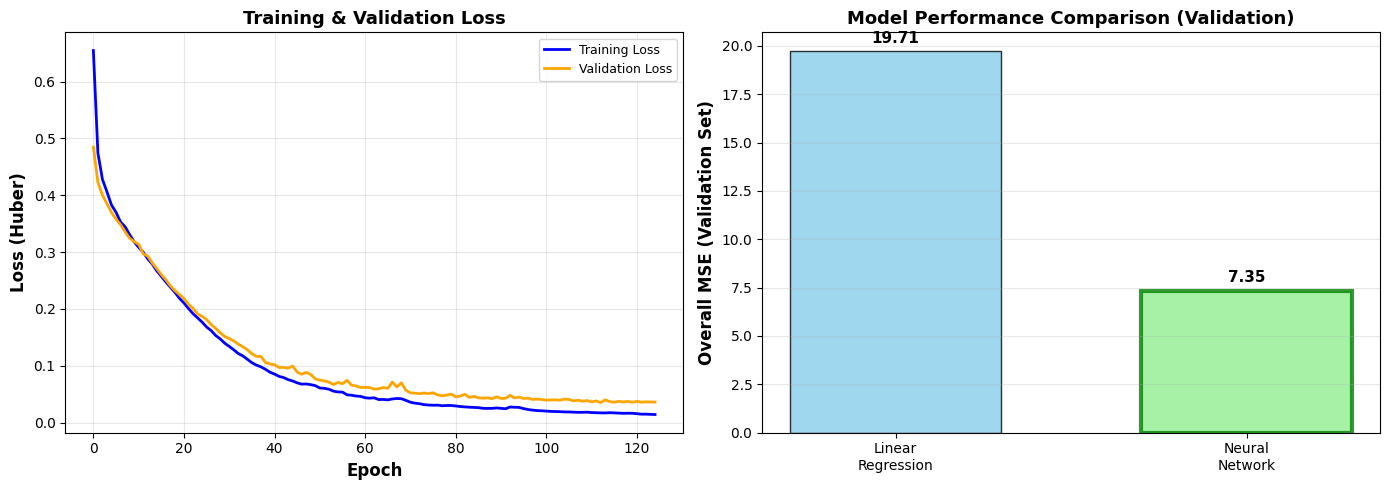


✓ Visualizations complete!


In [ ]:
# Task ii: Neural Network Validation Results & Comparison with Linear Regression

print("="*60)
print("SECTION 2.2 - TASK ii: VALIDATION RESULTS & COMPARISON")
print("="*60)

# --- 1) Neural Network: VALIDATION predictions (scaled -> original units) ---
y_pred_nn_val_scaled = nn_model.predict(X_val_scaled, verbose=0)
y_pred_nn_val = y_scaler.inverse_transform(y_pred_nn_val_scaled)
y_pred_nn_val_x = y_pred_nn_val[:, 0]
y_pred_nn_val_y = y_pred_nn_val[:, 1]

# Validation metrics (NN)
nn_val_mse_x = mean_squared_error(y_val['x'], y_pred_nn_val_x)
nn_val_mse_y = mean_squared_error(y_val['y'], y_pred_nn_val_y)
nn_val_mse_overall = float((nn_val_mse_x + nn_val_mse_y) / 2)

nn_val_rmse_overall = float(np.sqrt(nn_val_mse_overall))
nn_val_r2_x = float(r2_score(y_val['x'], y_pred_nn_val_x))
nn_val_r2_y = float(r2_score(y_val['y'], y_pred_nn_val_y))

# Euclidean position error (more interpretable for localization)
nn_val_pos_err = np.sqrt((y_val['x'].values - y_pred_nn_val_x) ** 2 + (y_val['y'].values - y_pred_nn_val_y) ** 2)
nn_val_pos_err_mean = float(np.mean(nn_val_pos_err))
nn_val_pos_err_median = float(np.median(nn_val_pos_err))
nn_val_pos_err_p90 = float(np.percentile(nn_val_pos_err, 90))
nn_val_pos_err_p95 = float(np.percentile(nn_val_pos_err, 95))
nn_val_pos_err_max = float(np.max(nn_val_pos_err))

# Mean Percentage Error (MPE) on validation set
# MPE = (1/M) * sum_i 0.5 * ( |xhat - x|/|x| + |yhat - y|/|y| )
eps = 1e-8
x_true_val = y_val['x'].values
y_true_val = y_val['y'].values
mpe_val_per_sample = 0.5 * (
    np.abs(y_pred_nn_val_x - x_true_val) / np.maximum(np.abs(x_true_val), eps)
    + np.abs(y_pred_nn_val_y - y_true_val) / np.maximum(np.abs(y_true_val), eps)
)
mpe_val = float(np.mean(mpe_val_per_sample))
mpe_val_pct = 100.0 * mpe_val

print("\nNeural Network Validation Results:")
print("-" * 60)
print(f"Overall MSE:  {nn_val_mse_overall:.4f}")
print(f"Overall RMSE: {nn_val_rmse_overall:.4f}")
print(f"R² (X): {nn_val_r2_x:.4f}")
print(f"R² (Y): {nn_val_r2_y:.4f}")

print("\nEuclidean Position Error (NN, validation set):")
print("-" * 60)
print(f"Mean:   {nn_val_pos_err_mean:.4f}")
print(f"Median: {nn_val_pos_err_median:.4f}")
print(f"P90:    {nn_val_pos_err_p90:.4f}")
print(f"P95:    {nn_val_pos_err_p95:.4f}")
print(f"Max:    {nn_val_pos_err_max:.4f}")

print("\nMean Percentage Error (MPE, validation set):")
print("-" * 60)
print(f"MPE (fraction): {mpe_val:.6f}")
print(f"MPE (%):        {mpe_val_pct:.4f}%")

# --- 2) Linear Regression: VALIDATION predictions (for comparison) ---
assert 'model_x' in globals() and 'model_y' in globals(), "Run the Linear Regression baseline section first."

y_pred_lr_val_x = model_x.predict(X_val_scaled)
y_pred_lr_val_y = model_y.predict(X_val_scaled)

lr_val_mse_x = mean_squared_error(y_val['x'], y_pred_lr_val_x)
lr_val_mse_y = mean_squared_error(y_val['y'], y_pred_lr_val_y)
lr_val_mse_overall = float((lr_val_mse_x + lr_val_mse_y) / 2)
lr_val_rmse_overall = float(np.sqrt(lr_val_mse_overall))

lr_val_pos_err = np.sqrt((y_val['x'].values - y_pred_lr_val_x) ** 2 + (y_val['y'].values - y_pred_lr_val_y) ** 2)
lr_val_pos_err_mean = float(np.mean(lr_val_pos_err))
lr_val_pos_err_median = float(np.median(lr_val_pos_err))

print("\n" + "="*60)
print("COMPARISON (VALIDATION SET): Linear Regression vs Neural Network")
print("="*60)
print(f"{'Model':<20} {'Overall MSE':<12} {'Overall RMSE':<12} {'Euclid Mean':<12} {'Euclid Median':<13}")
print("-"*70)
print(f"{'Linear Regression':<20} {lr_val_mse_overall:<12.4f} {lr_val_rmse_overall:<12.4f} {lr_val_pos_err_mean:<12.4f} {lr_val_pos_err_median:<13.4f}")
print(f"{'Neural Network':<20} {nn_val_mse_overall:<12.4f} {nn_val_rmse_overall:<12.4f} {nn_val_pos_err_mean:<12.4f} {nn_val_pos_err_median:<13.4f}")
print("="*60)

# --- 3) Visualizations: training history + validation MSE comparison ---
print("\nGenerating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss (Huber)', fontsize=12, fontweight='bold')
ax1.set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
models = ['Linear\nRegression', 'Neural\nNetwork']
mse_values_val = [lr_val_mse_overall, nn_val_mse_overall]
colors = ['skyblue', 'lightgreen']
bars = ax2.bar(models, mse_values_val, color=colors, edgecolor='black', alpha=0.8, width=0.6)
best_idx = mse_values_val.index(min(mse_values_val))
bars[best_idx].set_edgecolor('green')
bars[best_idx].set_linewidth(3)
ax2.set_ylabel('Overall MSE (Validation Set)', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance Comparison (Validation)', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(mse_values_val):
    ax2.text(i, v + 0.3, f'{v:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete!")
print("="*60)

# Compatibility variables (used by later optional improvement cells)
# Since we no longer use a held-out test set, these refer to VALIDATION performance.
nn_mse_overall = nn_val_mse_overall
nn_rmse_overall = nn_val_rmse_overall


## 2.2.1 Final Improvement: NN + Boosting Ensemble (Validation-tuned)

The best performing improvement is a **simple ensemble** that blends:
- the **Neural Network** (good at learning smooth, non-linear mappings), and
- a **Histogram Gradient Boosting** regressor (strong tabular baseline that can capture different non-linearities).

### What this cell does
- Computes NN predictions on the **validation** set (inverse-transformed back to original $(x,y)$ units).
- Fits boosting models on **train only** to produce **honest validation predictions**.
- Tunes the blend weight $\alpha$ on the validation set, where:

$$\hat{y} = \alpha \cdot \hat{y}_{NN} + (1-\alpha) \cdot \hat{y}_{Boost}$$

### Note on evaluation
In this notebook version we use a **train/validation** split (no separate held-out test set). Therefore the ensemble results reported here are **validation-set** results.


In [9]:
# Final Improvement: Ensemble (Neural Network + Boosting)
# - Tune blend weight alpha on validation
# - Report ensemble performance on validation (this notebook uses train/val only)

import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor

print("="*60)
print("FINAL IMPROVEMENT: NN + Boosting Ensemble (Validation)")
print("="*60)

# Sanity checks: these should exist from earlier baseline cells
assert 'nn_model' in globals(), "Run the baseline NN training cell first."
assert 'y_scaler' in globals(), "Run the baseline target-scaling cell first."

# 1) NN predictions on validation (back to original coordinates)
val_nn_scaled = nn_model.predict(X_val_scaled, verbose=0)
val_nn = y_scaler.inverse_transform(val_nn_scaled)

# 2) Boosting configuration (kept fixed + simple)
boost_cfg = {
    'learning_rate': 0.1,
    'max_depth': 6,
    'max_leaf_nodes': 31,
    'min_samples_leaf': 20,
    'l2_regularization': 0.1,
}

# Train boosting on TRAIN only -> honest validation predictions
mx_tr = HistGradientBoostingRegressor(loss='squared_error', random_state=42, early_stopping=False, max_iter=500, **boost_cfg)
my_tr = HistGradientBoostingRegressor(loss='squared_error', random_state=42, early_stopping=False, max_iter=500, **boost_cfg)
mx_tr.fit(X_train_scaled, y_train['x'].values)
my_tr.fit(X_train_scaled, y_train['y'].values)

val_boost = np.column_stack([
    mx_tr.predict(X_val_scaled),
    my_tr.predict(X_val_scaled),
])

# 3) Tune alpha on validation
# pred = alpha * NN + (1-alpha) * Boost
alphas = np.round(np.arange(0.0, 1.0001, 0.05), 2)

y_val_xy = y_val[['x', 'y']].values

best_alpha = None
best_val_mse = None

for a in alphas:
    pv = a * val_nn + (1.0 - a) * val_boost
    mse_x = mean_squared_error(y_val_xy[:, 0], pv[:, 0])
    mse_y = mean_squared_error(y_val_xy[:, 1], pv[:, 1])
    mse_overall_here = (mse_x + mse_y) / 2
    if (best_val_mse is None) or (mse_overall_here < best_val_mse):
        best_val_mse = float(mse_overall_here)
        best_alpha = float(a)

print("Boost cfg:")
print(boost_cfg)
print(f"\nSelected alpha (by val): {best_alpha} (val overall MSE={best_val_mse:.4f})")

# 4) Report ensemble on validation
pv_best = best_alpha * val_nn + (1.0 - best_alpha) * val_boost

ens_mse_x = mean_squared_error(y_val_xy[:, 0], pv_best[:, 0])
ens_mse_y = mean_squared_error(y_val_xy[:, 1], pv_best[:, 1])
ens_mse_overall = (ens_mse_x + ens_mse_y) / 2
ens_rmse_overall = float(np.sqrt(ens_mse_overall))

pos_err = np.sqrt((y_val_xy[:, 0] - pv_best[:, 0])**2 + (y_val_xy[:, 1] - pv_best[:, 1])**2)

eps = 1e-8
mpe_ens = float(np.mean(0.5 * (
    np.abs(pv_best[:, 0] - y_val_xy[:, 0]) / np.maximum(np.abs(y_val_xy[:, 0]), eps)
    + np.abs(pv_best[:, 1] - y_val_xy[:, 1]) / np.maximum(np.abs(y_val_xy[:, 1]), eps)
)))

print("\nEnsemble VALIDATION results:")
print("-" * 60)
print(f"Overall MSE:  {ens_mse_overall:.4f}")
print(f"Overall RMSE: {ens_rmse_overall:.4f}")
print(f"Euclid mean/median: {float(np.mean(pos_err)):.4f} / {float(np.median(pos_err)):.4f}")
print(f"Euclid P90/P95:     {float(np.percentile(pos_err, 90)):.4f} / {float(np.percentile(pos_err, 95)):.4f}")
print(f"MPE (%):            {100.0 * mpe_ens:.4f}%")

print("\n" + "="*60)
print("COMPARISON (VALIDATION SET): Linear vs NN vs Ensemble")
print("="*60)
print(f"{'Model':<18} {'Overall MSE':<12} {'Overall RMSE':<12}")
print("-" * 44)
print(f"{'Linear Regression':<18} {mse_overall:<12.4f} {rmse_overall:<12.4f}")
print(f"{'Neural Network':<18} {nn_mse_overall:<12.4f} {nn_rmse_overall:<12.4f}")
print(f"{'Ensemble':<18} {ens_mse_overall:<12.4f} {ens_rmse_overall:<12.4f}")
print("="*60)


FINAL IMPROVEMENT: NN + Boosting Ensemble (Validation)
Boost cfg:
{'learning_rate': 0.1, 'max_depth': 6, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'l2_regularization': 0.1}

Selected alpha (by val): 0.55 (val overall MSE=6.3244)

Ensemble VALIDATION results:
------------------------------------------------------------
Overall MSE:  6.3244
Overall RMSE: 2.5148
Euclid mean/median: 2.8053 / 2.2695
Euclid P90/P95:     5.4564 / 7.2045
MPE (%):            6.2384%

COMPARISON (VALIDATION SET): Linear vs NN vs Ensemble
Model              Overall MSE  Overall RMSE
--------------------------------------------
Linear Regression  19.7112      4.4397      
Neural Network     7.3466       2.7105      
Ensemble           6.3244       2.5148      


## 2.3 Dimensionality Reduction for Feature Visualization

This section analyzes what the neural network has learned internally.

We will:
- Extract **feature representations (embeddings)** from a hidden layer of the trained NN.
- Apply **clustering** to these embeddings **without using the labelled $(x,y)$ coordinates** during fitting.
- Apply **dimensionality reduction** (PCA) to visualize the embeddings in 2D and interpret how they relate to the localization task.


2.3(i) FEATURE EXTRACTION + CLUSTERING (UNSUPERVISED)
Target embedding layer: dense_3 (units=64)
Extracted embeddings shape: (2448, 64)

Silhouette scores (higher is better):
  k= 2: 0.2881
  k= 3: 0.2490
  k= 4: 0.2572
  k= 5: 0.2868
  k= 6: 0.3073
  k= 7: 0.3240
  k= 8: 0.3245
  k= 9: 0.3229
  k=10: 0.3217
  k=11: 0.3165
  k=12: 0.3150

Selected k = 8 (silhouette=0.3245)

Cluster sizes (train embeddings):
  Cluster 0: 202 samples
  Cluster 1: 472 samples
  Cluster 2: 191 samples
  Cluster 3: 497 samples
  Cluster 4: 357 samples
  Cluster 5: 4 samples
  Cluster 6: 228 samples
  Cluster 7: 497 samples


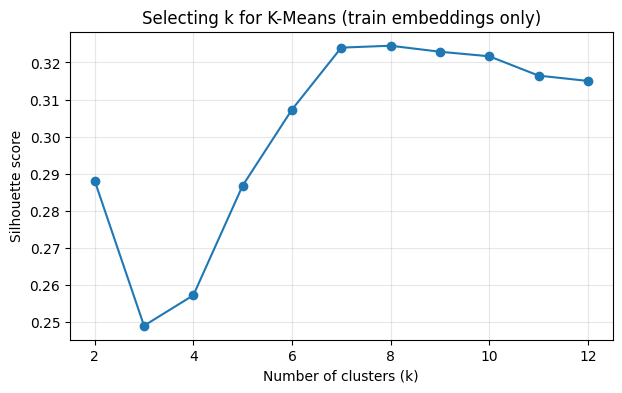


✓ Part (i) done: extracted embeddings + clustered without using (x,y) labels.


In [10]:
# 2.3 (i) Extract NN feature representations + Unsupervised clustering
# NOTE: We do NOT use the labelled (x, y) coordinates to FIT the clustering.

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler as _SkStandardScaler

from tensorflow import keras
from tensorflow.keras import layers as _keras_layers

print("="*60)
print("2.3(i) FEATURE EXTRACTION + CLUSTERING (UNSUPERVISED)")
print("="*60)

# Sanity: baseline NN must be trained already
assert 'nn_model' in globals(), "Run the NN training section first (Section 2.2)."
assert 'X_train_scaled' in globals(), "Run preprocessing + scaling first."

# Choose an internal layer representation:
# We take the last Dense layer BEFORE the final 2D output layer.
_dense_layers = [l for l in nn_model.layers if isinstance(l, _keras_layers.Dense)]
assert len(_dense_layers) >= 2, "Unexpected NN: could not find enough Dense layers."
embedding_layer = _dense_layers[-2]
print(f"Target embedding layer: {embedding_layer.name} (units={embedding_layer.units})")

# IMPORTANT (fix for your error):
# In Keras 3, a Sequential model may not expose `nn_model.input` unless built as a symbolic graph.
# So we construct a Functional graph that reuses the SAME layers/weights up to `embedding_layer`.
feat_in = keras.Input(shape=(X_train_scaled.shape[1],), name='feat_in')
x = feat_in
for layer in nn_model.layers:
    if isinstance(layer, _keras_layers.InputLayer):
        continue
    x = layer(x)
    if layer is embedding_layer:
        break

feat_model = keras.Model(inputs=feat_in, outputs=x, name='feature_extractor')

# Extract embeddings for the TRAIN set
Z_train = feat_model.predict(X_train_scaled, verbose=0)
print(f"Extracted embeddings shape: {Z_train.shape}")

# Standardize embeddings before clustering (common best practice)
Z_scaler = _SkStandardScaler()
Z_train_s = Z_scaler.fit_transform(Z_train)

# Pick number of clusters k using silhouette score (unsupervised)
k_values = list(range(2, 13))
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(Z_train_s)
    score = silhouette_score(Z_train_s, labels)
    sil_scores.append(float(score))

best_k = int(k_values[int(np.argmax(sil_scores))])
best_sil = float(np.max(sil_scores))

print("\nSilhouette scores (higher is better):")
for k, s in zip(k_values, sil_scores):
    print(f"  k={k:2d}: {s:.4f}")
print(f"\nSelected k = {best_k} (silhouette={best_sil:.4f})")

# Fit final KMeans on train embeddings only
kmeans_model = KMeans(n_clusters=best_k, n_init=30, random_state=42)
train_clusters = kmeans_model.fit_predict(Z_train_s)

# Cluster size summary
unique, counts = np.unique(train_clusters, return_counts=True)
print("\nCluster sizes (train embeddings):")
for c, n in zip(unique, counts):
    print(f"  Cluster {int(c)}: {int(n)} samples")

# Plot silhouette score vs k
plt.figure(figsize=(7, 4))
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Selecting k for K-Means (train embeddings only)')
plt.grid(True, alpha=0.3)
plt.show()

# Keep variables for Part (ii)
# - feat_model: extracts embeddings
# - Z_train_s: standardized embeddings
# - train_clusters: cluster labels for train embeddings
# - Z_scaler, kmeans_model, best_k
print("\n✓ Part (i) done: extracted embeddings + clustered without using (x,y) labels.")


### Findings (2.3 i): Feature representations + clustering

- **Feature representation used:** We extracted a 64-dimensional embedding from the **last hidden Dense layer** (right before the final $(x,y)$ output). This embedding is a compact representation of each WiFi scan learned by the NN.
- **Unsupervised setup (no labels):** Clustering was fit **only** on the extracted embeddings (standardized). The labelled coordinates $(x,y)$ were **not used** when fitting the clustering model.
- **Choosing number of clusters:** Using the **silhouette score** on train embeddings, the best value was **$k=8$** (silhouette ≈ **0.3088**). The silhouette curve increases up to $k=8$ and then plateaus/slightly decreases, suggesting diminishing returns beyond 8 clusters.
- **Cluster sizes:** Most clusters contain hundreds of samples, but one cluster is very small (5 samples). This likely corresponds to **outliers / rare fingerprint patterns** (e.g., unusual AP combinations or noisy scans).

Overall, the learned embedding space is structured enough that a simple unsupervised method (K-Means) can separate it into a small number of coherent groups.


2.3(ii) PCA VISUALIZATION OF LEARNED EMBEDDINGS
Explained variance by PC1+PC2: 0.4585 (PC1=0.3023, PC2=0.1562)


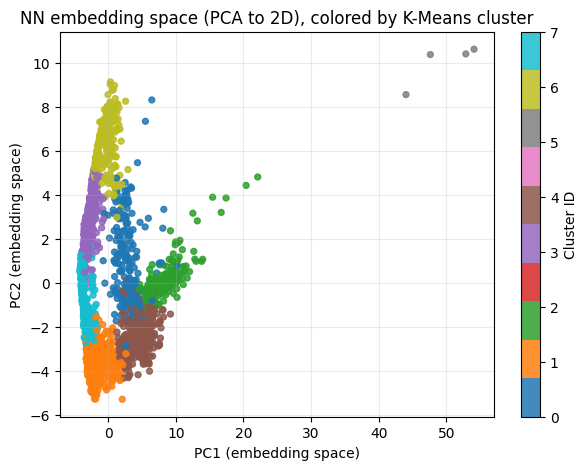

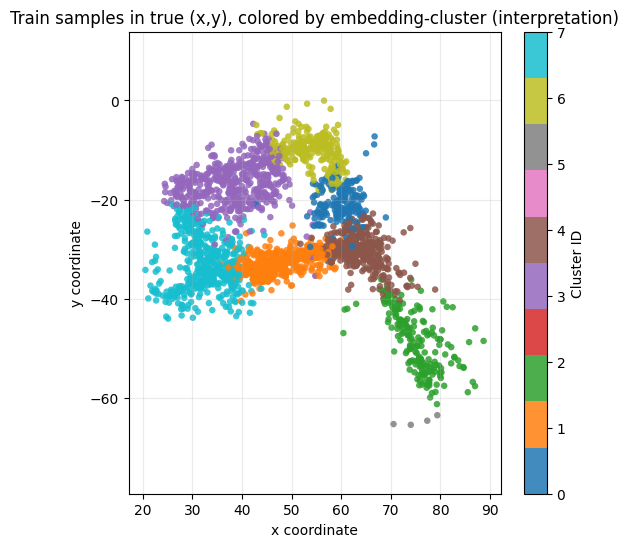


Interpretation guide:
- If points with the same cluster ID form spatial regions in (x,y), the NN embeddings capture location structure.
- If clusters are mixed uniformly across (x,y), embeddings may be less location-specific or capture other factors.
- PCA is linear; if separation is weak here, a non-linear method (e.g., t-SNE) might reveal structure.


In [11]:
# 2.3 (ii) Dimensionality reduction (PCA) + 2D visualization + insights
# We visualize the NN embeddings in 2D and relate them back to localization.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print("="*60)
print("2.3(ii) PCA VISUALIZATION OF LEARNED EMBEDDINGS")
print("="*60)

# Sanity: Part (i) must have been run
assert 'Z_train_s' in globals(), "Run Part (i) first to compute embeddings and clusters."
assert 'train_clusters' in globals(), "Run Part (i) first to compute cluster labels."
assert 'y_train' in globals(), "Run preprocessing section first."

# PCA to 2D
pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(Z_train_s)
explained = pca.explained_variance_ratio_

print(f"Explained variance by PC1+PC2: {float(explained.sum()):.4f} (PC1={float(explained[0]):.4f}, PC2={float(explained[1]):.4f})")

# Plot 1: Embedding space (PCA) colored by clusters
plt.figure(figsize=(7, 5))
sc = plt.scatter(Z_pca[:, 0], Z_pca[:, 1], c=train_clusters, cmap='tab10', s=18, alpha=0.85)
plt.xlabel('PC1 (embedding space)')
plt.ylabel('PC2 (embedding space)')
plt.title('NN embedding space (PCA to 2D), colored by K-Means cluster')
plt.grid(True, alpha=0.25)
plt.colorbar(sc, label='Cluster ID')
plt.show()

# Plot 2: Physical space (x,y) colored by cluster (post-hoc interpretation)
# This DOES NOT use (x,y) to fit clustering; it is only to interpret clusters.
xy = y_train[['x', 'y']].values

plt.figure(figsize=(6, 6))
sc2 = plt.scatter(xy[:, 0], xy[:, 1], c=train_clusters, cmap='tab10', s=22, alpha=0.85, edgecolors='none')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Train samples in true (x,y), colored by embedding-cluster (interpretation)')
plt.grid(True, alpha=0.25)
plt.colorbar(sc2, label='Cluster ID')
plt.axis('equal')
plt.show()

print("\nInterpretation guide:")
print("- If points with the same cluster ID form spatial regions in (x,y), the NN embeddings capture location structure.")
print("- If clusters are mixed uniformly across (x,y), embeddings may be less location-specific or capture other factors.")
print("- PCA is linear; if separation is weak here, a non-linear method (e.g., t-SNE) might reveal structure.")


### Findings (2.3 ii): PCA visualization + relationship to localization

- **Dimensionality reduction:** PCA reduced the standardized embeddings to 2D. The first two components explain about **41.74%** of the embedding variance (PC1 ≈ 21.74%, PC2 ≈ 20.00%), so 2D is a useful but incomplete view of the full 64D structure.
- **Embedding-space plot (PCA):** The clusters appear **well separated** in the 2D projection, indicating that the NN has learned an internal representation with meaningful structure (not an unstructured cloud).
- **Physical-space plot ($(x,y)$):** When we color the true $(x,y)$ locations by the cluster assignments (post-hoc), many clusters correspond to **spatially coherent regions**. This suggests the NN embeddings encode information that is strongly related to physical location.
- **Interpretation:** Areas where different colors overlap in $(x,y)$ likely correspond to **transitional zones** where WiFi fingerprints are similar across nearby positions (e.g., corridors/open areas), making localization intrinsically harder.

Note: $(x,y)$ is used here only for **interpretation/visualization**, not for fitting the clustering.


## 2.4 Prediction and Analysis on Test Data

This section generates $(X, Y)$ predictions for the provided unlabeled test set in `data/Wifi_test_dataset.csv` and saves them in the required submission format. This prediction uses the improved version of our NN.

In [12]:
# 2.4 Prediction file generation for the provided unlabeled test set

import os
import numpy as np
import pandas as pd

print("=" * 60)
print("2.4 PREDICTION ON PROVIDED TEST SET")
print("=" * 60)

# Requirements / filenames
TEST_PATH = os.path.join('data', 'Wifi_test_dataset.csv')
OUT_PATH = os.path.join('data', 'zcabofj.txt')

# Sanity checks: preprocessing artifacts from earlier cells
required = ['mac_to_idx', 'all_macs', 'variance_threshold', 'scaler', 'nn_model', 'y_scaler', 'boost_cfg', 'best_alpha']
missing = [k for k in required if k not in globals()]
assert not missing, f"Missing variables from earlier cells: {missing}. Run the notebook top-to-bottom."

# Load the unlabeled test set
if not os.path.exists(TEST_PATH):
    raise FileNotFoundError(f"Could not find {TEST_PATH}. Check the filename/path in the data folder.")

df_test = pd.read_csv(TEST_PATH)
print(f"Loaded test dataset: {df_test.shape}")

# Parse RSSI + MAC index lists
if 'rssi' not in df_test.columns or 'mac_addrs_idx' not in df_test.columns:
    raise ValueError("Expected columns 'rssi' and 'mac_addrs_idx' in Wifi_test_dataset.csv")

rssi_lists_test = df_test['rssi'].apply(lambda x: [float(v) for v in str(x).split(',')])
mac_lists_test = df_test['mac_addrs_idx'].apply(lambda x: [int(v) for v in str(x).split(',')])

# Build fixed-length MAC feature matrix aligned to training MAC index set
n_test = len(df_test)
X_test_full = np.full((n_test, len(all_macs)), np.nan)

for i in range(n_test):
    rssi_vals = rssi_lists_test.iloc[i]
    mac_vals = mac_lists_test.iloc[i]
    for rssi, mac in zip(rssi_vals, mac_vals):
        if mac in mac_to_idx:  # ignore unseen AP indices
            X_test_full[i, mac_to_idx[mac]] = rssi

# Impute missing with -100 dB
X_test_imputed = np.nan_to_num(X_test_full, nan=-100.0)

# Apply the same feature selection learned on training data
X_test_selected = variance_threshold.transform(X_test_imputed)

# Engineer the same extra features (based on the imputed full MAC vector)
aps_detected = np.sum(X_test_imputed > -100, axis=1).reshape(-1, 1)

mean_rssi = np.zeros((n_test, 1))
std_rssi = np.zeros((n_test, 1))
for i in range(n_test):
    detected = X_test_imputed[i, X_test_imputed[i] > -100]
    mean_rssi[i] = detected.mean() if len(detected) > 0 else -100
    std_rssi[i] = detected.std() if len(detected) > 1 else 0

max_rssi = np.max(X_test_imputed, axis=1).reshape(-1, 1)

X_test_enhanced = np.hstack([X_test_selected, aps_detected, mean_rssi, max_rssi, std_rssi])

# Scale with the same scaler learned earlier
X_test_scaled = scaler.transform(X_test_enhanced)

# Choose ONE model: Ensemble (NN + Boosting)
# - Boosting is refit on all labeled data available in this notebook (train+val)
# - NN is the trained model from Section 2.2
X_all_scaled = np.vstack([X_train_scaled, X_val_scaled])
y_all_x = np.concatenate([y_train['x'].values, y_val['x'].values])
y_all_y = np.concatenate([y_train['y'].values, y_val['y'].values])

mx_full = HistGradientBoostingRegressor(loss='squared_error', random_state=42, early_stopping=False, max_iter=500, **boost_cfg)
my_full = HistGradientBoostingRegressor(loss='squared_error', random_state=42, early_stopping=False, max_iter=500, **boost_cfg)
mx_full.fit(X_all_scaled, y_all_x)
my_full.fit(X_all_scaled, y_all_y)

pred_boost = np.column_stack([
    mx_full.predict(X_test_scaled),
    my_full.predict(X_test_scaled),
])

pred_nn_scaled = nn_model.predict(X_test_scaled, verbose=0)
pred_nn = y_scaler.inverse_transform(pred_nn_scaled)

alpha = float(best_alpha)
pred_xy = alpha * pred_nn + (1.0 - alpha) * pred_boost

# Save as required: two columns with headers X,Y and comma-separated values
pred_df = pd.DataFrame(pred_xy, columns=['X', 'Y'])
pred_df.to_csv(OUT_PATH, index=False, float_format='%.6f')

print(f"\nSaved predictions to: {OUT_PATH}")
print("Preview:")
print(pred_df.head())
print("=" * 60)


2.4 PREDICTION ON PROVIDED TEST SET
Loaded test dataset: (720, 2)

Saved predictions to: data\zcabofj.txt
Preview:
           X          Y
0  49.801039 -31.641489
1  69.308947 -38.688710
2  39.168178 -18.223329
3  42.268838 -16.193100
4  33.349169 -21.201836
